In [5]:
%pip install convertdate

  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached PyMeeus-0.5.11-py3-none-any.whl



You should consider upgrading via the 'c:\users\krister\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import convertdate
import re
import json

In [514]:
main_df = pd.read_parquet('../data/RZ_sample.parquet')

In [9]:
weekdays = ['Montag', 'Montage', 'Dienstag', 'Dienstage', 'Dinstag', 'Mittwoch', 'Donnerstag', 'Donnerstage',
            'DonnerStag', 'DienStag', 'DienStage', 'DinStag',
            'Freitag', 'Freytag', 'Freitage', 'Sonntag', 'Sonnabend', 'Sonntage', 'Stag', 'Tage',
            'Gestern', 'Morgen']
months = ['Januar', 'Februar', 'März', 'April', 'Juni', 'Juny', 'Juli', 'July', 'August',
          'October', 'Oktober', 'November', 'December', 'Dezember']
times_of_day = ['Abend', 'Heute']
currencies = ['Thlr']
other = ['Fremde', 'Hotel', 'Adler', 'Rathhaus', 'Riga-Rathhaus', 'Riga-RathhauS', 'Riga-Schloß', 'Geldkurs', 'Hause',
         'Tgbf', 'Börse', 'Pastorat', 'Senat', 'Schmidt', 'Verwaltung', 'Bekanntmachungen', 'Anzeige', 'Jahre',
         'Tagesbefehle', 'Schloß', 'Ritterhause', 'Weihnachtsabend']

exceptions = weekdays + months + times_of_day + currencies + other

In [515]:
with open('../data/re_exceptions.txt', 'r', encoding='utf8') as f:
    exceptions = []
    for line in f.readlines():
        exceptions.append(line.strip('\n'))

In [516]:
with open('../data/re_pattern2.txt', 'r', encoding='utf8') as f:
    pattern = re.compile(f.read(), flags=re.MULTILINE)

In [307]:
def pattern_test():

    for ix, row in main_df.iterrows():
        matches = list(re.finditer(pattern, row.full_text))
        if len(matches) > 0:
            
            return row.full_text, matches
        

In [309]:
text, matches = pattern_test()
print(text)
print(matches[0].groupdict())

Lissabon, den 30. Oktober.

	Die Staatszeitung versichert, daß btt französische Geschäftsträger unsenn Ministerium angezeigt: Frankreich habe keine feindliche Absicht wider Spanien und noch, weniger wider Portugal, und die Pyre» väen» Armee keinen andern Zweck, al-5

	baß Frankreich nicht durch Spanien, bei der Gährung, die in dem letzteren Herr» sche, beunruhigt werde. Auch unser Geschäftsträger zu London ist von Herrn Canning im Namen der britischen Regierung benachrichtigt worden, daß das Ge» rücht einer Invasion der Halbinsel völlig falsch sey, und daß in allen Fällen Eng« land seinen alten Freund und Bundcsge» Nossen, Portugal, nie verlassen werde.
{'placename': 'Lissabon', 'DATE2': None, 'date2': None, 'month2': None, 'date2_par': None, 'month2_par': None, 'DATE': '30. Oktober', 'date': '30', 'date_par': None, 'month': 'Okt', 'year': None}


In [529]:
def get_text(ix, window):
    window_before, window_after = window, window
    if window_before > df.loc[ix, 'start']:
        window_before = df.loc[ix, 'start']
        
    return main_df.loc[df.loc[ix, 'doc_id'], 'full_text'][df.loc[ix, 'start']-window_before:df.loc[ix, 'end']+window_after]
    
    
def get_example(placename, window=200):
    example = df.loc[df.placename == placename].sample(1)
    ix = example.index.values[0]
    doc_id = example.doc_id.values[0]
    print('doc_id: ', doc_id, '\n') 
    if window == 'full':
        print(main_df.loc[doc_id, 'full_text'], '\n')
    else:
        print(get_text(ix, window), '\n')
    for match in re.finditer(pattern, main_df.loc[doc_id, 'full_text']):
        print(match.groupdict())
        
        
def extract_data_from_match(match):
    m = match.groupdict()
    if m['DATE2'] is None:
        return [m['placename'], m['date'], m['date_par'], m['month'], m['month2'], m['year'],
                match.span()[0], match.span()[1]]
    elif m['DATE'] is None:
        return [m['placename'], m['date2'], m['date2_par'], m['month2'], m['month2_par'], m['year'],
                match.span()[0], match.span()[1]]

        
def scan_placenames_dates(main_df):
    
    results = []
    
    for ix, row in tqdm(main_df.iterrows()):
        matches = list(re.finditer(pattern, row.full_text))
        for m in matches:
            #results.append([ix, row.date] + list(m.groupdict().values()) + [m.span()[0], m.span()[1]])
            results.append([ix, row.date] + extract_data_from_match(m))
        
    result_df = pd.DataFrame(columns=['doc_id',
                                      'doc_date',
                                      'placename',
                                      'day',
                                      'day2',
                                      'month',
                                      'month2',
                                      'origin_year',
                                      'start',
                                      'end'],
                             data=results).fillna(pd.NA)
    
    result_df['doc_date'] = pd.to_datetime(result_df['doc_date'], format='%Y-%m-%d')
    #result_df['doc_year'] = result_df['doc_date'].dt.year
    
    result_df['origin_year'].fillna(0, inplace=True)
    result_df['origin_year'] = result_df['origin_year'].astype(int)
    result_df['origin_year'] = result_df['origin_year'].apply(lambda x: x if (x in range(1800, 1891)) else pd.NA)
    result_df['origin_year'].replace(0, pd.NA, inplace=True)
    
    for col in ['day', 'day2']:
        
        result_df[col] = result_df[col].str.lstrip('( ').str.strip('.) ')
        result_df[col].fillna(0, inplace=True)
        result_df[col] = result_df[col].astype(int)
        result_df[col] = result_df[col].apply(lambda x: x if (x in range(1,32)) else pd.NA)
        result_df[col].replace(0, pd.NA, inplace=True)
        
    return result_df[~result_df.placename.isin(exceptions)]

In [530]:
df = scan_placenames_dates(main_df)

0it [00:00, ?it/s]

In [80]:
def example():
    
    example_ix = df.sample().doc_id.values[0]

    for ix, row in df[df.doc_id == example_ix].iterrows():
        print(row.loc[['placename', 'date_full', 'date2_full']], '\n')
    print('\n\n', main_df.loc[row['doc_id'], 'full_text'])

In [531]:
print(df.placename.value_counts().sum())
print(df.placename.value_counts()[lambda x: x >= 30].sum())

8615
6363


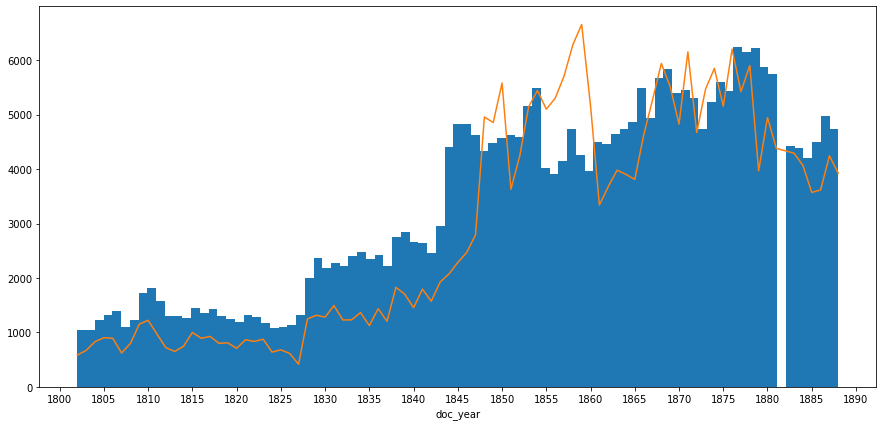

In [378]:
plt.figure(figsize=(15,7))
main_df.year.hist(bins=87)
df.groupby('doc_year')['doc_year'].count().plot()
plt.xticks(range(1800,1891,5))
plt.show()

In [532]:
with open('../data/placename_replacement_dict.json', 'r', encoding='utf8') as f:
    placename_replacement_dict = json.load(f)

df.placename.replace(placename_replacement_dict, inplace=True)

In [428]:
def cleanup_dates(df):
    
    #df = df.copy()
    
    month_dict = dict(zip(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun',
                           'Jul', 'Aug', 'Sept', 'Okt', 'Nov', 'Dec'], range(1,13)))
    
    for col in ['month', 'month2']:
    
        df[col] = df[col].str.capitalize()
        df[col].replace({'Dez': 'Dec', 'Mar': 'Mär', 'Oct': 'Okt', '0ct': 'Okt', '0kt': 'Okt', 'Ocl': 'Okt',
                         'Spt': 'Sept', 'Jnl': 'Jul', 'Jnn': 'Jun', 'Juu': 'Jun', 'Jnu': 'Jun', 'May': 'Mai'}, inplace=True)
        
        df[col].replace(month_dict, inplace=True)
        df.loc[df[col].isin(['C', 'C.', 'D. m', 'D. m.']), col] = df.loc[df[col].isin(['C', 'C.', 'D. m', 'D. m.']), 'doc_date'].dt.month
        df.loc[df[col].isin(['V. m', 'V. m.']), 'month'] = (df.loc[df[col].isin(['v. M', 'V. m.']), 'doc_date'] - pd.DateOffset(months=1)).dt.month - 1
        
        df[col] = df[col].fillna(0).astype(int)
        df[col] = df[col].apply(lambda x: x if (x in range(1,13)) else pd.NA)
        
    
    return df 

In [533]:
df = cleanup_dates(df)

In [568]:
def verify_dates(ix, df=df):
    
    """Function to find the logically correct date from the information found by the regular expression.
    Has different approaches depending on the number of dates and months detected. In the case of multiple
    possibilities, returns the earlier one (corresponding to the Julian calendar)."""
    
    #print(df.loc[ix,['day', 'day2', 'month', 'doc_date']].values)
    
    day, day2, month, month2, origin_year, doc_date = [value if type(value) != pd._libs.missing.NAType else None
                                          for value in df.loc[ix,['day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].values]
    
    path = []
    
    # if 
    if day is None or month is None:
        path.append(0)
        return pd.NA
    
    ### two dates, two months
    if None not in [day, day2, month, month2]:
        path.append(1)
        
        if origin_year:
            origin_date = min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
            
        # exception for december/january  
        elif month == 1 and month2 == 12:
            if doc_date.month == 12:
                return pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            else: 
                return pd.to_datetime(f'{str(doc_date.year-1)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
                        
        # if both months come after publication month, news is probably from last year
        elif month > doc_date.month and month2 > doc_date.month:
            
                path.append(1.1)
                possible_origin_dates = []
                for d, m in zip([day, day2], [month, month2]):
                    origin_year = doc_date.year - 1
                    possible_origin_dates.append(
                            pd.to_datetime(f'{str(origin_year)}-{m}-{d}', format='%Y-%m-%d', errors='coerce'))
                        
                return min(possible_origin_dates)
        
        # normal proceeding
        else:
            path.append(1.2)
            # julian is the smaller one
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
       
    
    ### two dates, one month
    elif day and day2 and month:
        path.append(2)
        
        if origin_year:
            return min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
        
        # if month is the same or precedes the publication month
        elif month == doc_date.month or month < doc_date.month:
            path.append(2.1)
            
            # julian is the smaller one
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
       
        # if month follows publication month
        elif month > doc_date.month:
            path.append(2.2)
            
            # formulate dates for both possibilities
            origin_date = min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'))
             
            # is the smaller one more than 12 days later than publication date?
            if origin_date - doc_date > pd.Timedelta(days=12):
                # so the news is from last year
                return origin_date - pd.DateOffset(years=1)
            else:
                # if not, it is probably a georgian date a few days ahead of the julian publication date
                try:
                    day_jul = convertdate.julian.from_gregorian(year=origin_date.year,
                                                                    month=origin_date.month, day=origin_date.day)
                except ValueError:
                    return pd.NA
                
                return pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}',
                                             format='%Y-%m-%d', errors='coerce')

            
    # one day, one month
    elif day and month:
        path.append(3)            
        
        # if month precedes publication month
        if month < doc_date.month:
            path.append(3.1)
            # (probably) julian
            return pd.to_datetime(f'{origin_year if origin_year else str(doc_date.year)}-{month}-{day}',
                                         format='%Y-%m-%d', errors='coerce')
        
        # if month is the same as publication month
        elif month == doc_date.month:
            path.append(3.2)
            
            # if the day is later than the publication day, within the same month
            if day > doc_date.day:
                path.append(3.21)
                
                # origin is gregorian, convert to julian first, then apply
                try:
                    day_jul = convertdate.julian.from_gregorian(year=origin_year if origin_year else doc_date.year,
                                                                    month=month, day=day)
                except ValueError:
                    return pd.NA
                
                return pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}',
                                             format='%Y-%m-%d', errors='coerce')
            
            # if the day precedes the publication day, within the same month
            else:
                path.append(3.22)
                # origin is (probably) julian
                return pd.to_datetime(f'{origin_year if origin_year else str(doc_date.year)}-{month}-{day}',
                                             format='%Y-%m-%d', errors='coerce')
        
        
        # if month is greater than publication month
        elif month > doc_date.month:
            path.append(3.3)
            
            if origin_year:
                return pd.to_datetime(f'{origin_year}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
                
            else:
                origin_date = pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
             
                # is the difference more than 12 days compared to the publication date?
                if origin_date - doc_date > pd.Timedelta(days=12):
                    # so the news is from last year
                    return origin_date - pd.DateOffset(years=1)
                else:
                    # if not, it is probably a georgian date a few days ahead of the julian publication date
                    try:
                        day_jul = convertdate.julian.from_gregorian(year=origin_date.year,
                                                                        month=origin_date.month, day=origin_date.day)
                    except ValueError:
                        return pd.NA
                
                    return pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}',
                                                 format='%Y-%m-%d', errors='coerce')

In [569]:
origin_dates = []
for ix in tqdm(df.index):
    origin_dates.append(verify_dates(ix, df))

df['origin_date'] = origin_dates

  0%|          | 0/8590 [00:00<?, ?it/s]

In [570]:
df.dropna(subset=['origin_date'], inplace=True)
df['origin_date'] = pd.to_datetime(df.origin_date)

In [571]:
df['delta'] = (df['doc_date'] - df['origin_date']).dt.days

In [119]:
df = pd.read_csv('../streamlit/streamlit_data.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0')
placenames = df.columns

In [120]:
df

,Paris,London,Berlin,St. Petersburg,Wien,Madrid,Konstantinopel,Rom,Brüssel,Kopenhagen,...,Pensa,Galatz,Grangemouth,Kadir,Schaffhausen,Pillau,Southampton,Helvoet,Pskow,Santander
1802,11.614583,11.294118,7.272727,11.131868,12.814815,NaN,35.214286,27.500000,10.666667,NaN,...,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
1803,10.600000,13.115789,9.428571,12.490385,12.562500,30.250000,34.384615,25.000000,9.884615,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804,11.669231,13.900000,6.000000,14.387387,13.837838,30.428571,39.210526,25.428571,9.666667,7.764706,...,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1805,11.794872,13.814815,7.972222,12.349057,13.716981,26.222222,41.045455,29.111111,9.000000,7.083333,...,NaN,NaN,NaN,29.6,NaN,NaN,NaN,NaN,NaN,NaN
1806,12.914286,14.392405,8.513514,14.574074,16.580000,34.333333,39.550000,32.714286,NaN,9.411765,...,NaN,NaN,NaN,NaN,NaN,22.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,2.249344,1.808511,1.825301,1.726415,2.062500,2.000000,1.526316,1.852941,1.916667,1.777778,...,2.0,NaN,NaN,NaN,NaN,7.0,2.0,NaN,NaN,NaN
1885,2.312704,1.791096,1.681818,2.189781,1.937500,2.552941,1.350000,2.500000,4.028571,1.897436,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1886,2.324627,1.832727,1.754386,1.836842,2.071713,2.135135,1.481481,2.456140,2.425000,1.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1887,2.059211,1.961207,1.677922,1.682540,1.927711,2.409091,1.941176,1.960938,2.364865,1.833333,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
corr = st_df.loc[:, st_df.columns[:50]].corr()

In [196]:
corr.style.background_gradient(cmap ='coolwarm').to_excel('../data/corr.xlsx')

In [197]:
corr.style.background_gradient(cmap ='coolwarm')

,Paris,London,Berlin,St. Petersburg,Wien,Madrid,Konstantinopel,Rom,Brüssel,Kopenhagen,New York,München,Riga,Hamburg,Turin,Bern,Dorpat,Dresden,Reval,Stockholm,Warschau,Domesnees,Florenz,Odessa,Neapel,Haag,Amsterdam,Athen,Lissabon,Hannover,Stuttgart,Bukarest,Triest,Versailles,Moskau,Karlsruhe,Main,Kassel,Belgrad,Budapest,Kiel,Leipzig,Frankfurt am Main,Köln,Italien,Washington,Königsberg,Darmstadt,Mailand,Breslau
Paris,1.000000,0.915437,0.683341,0.589603,0.855081,0.662653,0.709973,0.720012,0.860532,0.797449,0.650468,0.852811,-0.293214,0.402732,0.506828,0.771291,0.654530,0.731006,0.604712,0.842497,0.562303,0.735577,0.628304,0.728337,0.695088,0.874058,0.773505,0.153778,0.687301,0.697042,0.681614,0.677225,0.764850,0.479288,0.649406,0.505507,0.733416,0.716464,0.497842,0.962795,0.537270,0.597767,0.617091,0.709052,0.579585,0.778409,0.630226,0.593683,0.763274,0.614466
London,0.915437,1.000000,0.711398,0.638302,0.905222,0.722486,0.752823,0.767065,0.925377,0.823373,0.751324,0.863551,-0.297575,0.517010,0.628514,0.868471,0.665989,0.792254,0.716736,0.878462,0.568067,0.812970,0.761044,0.824731,0.708450,0.859793,0.789631,0.318571,0.768087,0.645410,0.718879,0.722931,0.859235,0.273036,0.666038,0.629899,0.780786,0.710133,0.690654,0.982090,0.626698,0.691067,0.711907,0.693947,0.628145,0.794363,0.652511,0.649865,0.772384,0.696549
Berlin,0.683341,0.711398,1.000000,0.551592,0.763596,0.676936,0.752725,0.680909,0.527126,0.701026,0.738657,0.612434,-0.475134,0.635443,0.612543,0.565980,0.538676,0.813176,0.647855,0.646196,0.575208,0.923758,0.560108,0.718843,0.718970,0.688219,0.725033,0.285959,0.690886,0.611298,0.730028,0.724225,0.698875,-0.629502,0.758490,0.668484,0.651718,0.675427,0.612181,0.920570,0.725633,0.744091,0.626334,0.765093,0.357019,0.789068,0.635475,0.606351,0.704639,0.705750
St. Petersburg,0.589603,0.638302,0.551592,1.000000,0.675931,0.769408,0.815350,0.803621,0.521974,0.551007,0.738957,0.597434,-0.517595,0.291806,0.703712,0.877841,0.559684,0.595531,0.729566,0.608814,0.586009,0.865594,0.773239,0.695969,0.778434,0.567333,0.490111,0.693160,0.757528,0.287467,0.573639,0.704032,0.712685,-0.614041,0.806776,0.534164,0.260034,0.609138,0.822508,0.936603,0.567921,0.559717,0.366593,0.678494,0.318998,0.886041,0.602174,0.652745,0.762866,0.506503
Wien,0.855081,0.905222,0.763596,0.675931,1.000000,0.738298,0.762055,0.782387,0.776607,0.808742,0.776440,0.848930,-0.360017,0.472596,0.726403,0.891442,0.623042,0.823981,0.765101,0.827098,0.618601,0.720844,0.795554,0.898411,0.770132,0.805894,0.751076,0.290651,0.768655,0.560736,0.757869,0.752544,0.887492,0.601129,0.703470,0.603508,0.853519,0.659797,0.734283,0.902303,0.673485,0.758420,0.826563,0.652344,0.680825,0.853964,0.628175,0.588258,0.838343,0.677336
Madrid,0.662653,0.722486,0.676936,0.769408,0.738298,1.000000,0.929876,0.952520,0.569468,0.473345,0.867747,0.688663,-0.513806,0.299640,0.889488,0.794963,0.454038,0.655627,0.646388,0.807173,0.506379,-0.240543,0.912671,0.806358,0.905720,0.501842,0.467561,0.795824,0.930981,0.445388,0.529519,0.852003,0.857067,-0.397926,0.726182,0.479636,0.396178,0.509562,0.937721,0.973497,0.408316,0.632365,0.473800,0.449419,0.621673,0.906499,0.636426,0.545132,0.898409,0.556408
Konstantinopel,0.709973,0.752823,0.752725,0.815350,0.762055,0.929876,1.000000,0.944078,0.577004,0.559667,0.950021,0.672527,-0.519381,0.397570,0.862064,0.802826,0.541376,0.735642,0.710904,0.785897,0.471067,0.771543,0.887738,0.841038,0.936556,0.520375,0.519382,0.880472,0.951825,0.494740,0.601505,0.914593,0.857204,-0.609929,0.759101,0.628298,0.364040,0.547068,0.931736,0.969009,0.538468,0.649796,0.484517,0.522830,0.510601,0.946231,0.672667,0.617571,0.894768,0.613661
Rom,0.720012,0.767065,0.680909,0.803621,0.782387,0.952520,0.944078,1.000000,0.610814,0.522418,0.904475,0.746481,-0.510837,0.297146,0.885869,0.848545,0.480082,0.711145,0.601222,0.813883,0.477188,-0.041927,0.923805,0.779562,0.924732,0.523924,0.500852,0.911403,0.931116,0.439119,0.533160,0.871835,0.898119,0.052807,0.721289,0.578554,0.419363,0.510296,0.860327,0.9862

KeyError: "None of [Int64Index([1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812,\n            1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823,\n            1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834,\n            1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845,\n            1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856,\n            1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867,\n            1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878,\n            1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888],\n           dtype='int64')] are in the [columns]"

<Figure size 1080x504 with 0 Axes>

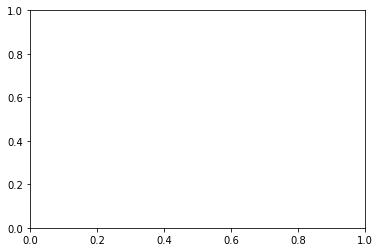

In [188]:
plt.figure(figsize=(15,7))
st_df.plot.scatter(x=st_df.index.values, y=st_df.loc[:,st_df.columns])
plt.show()

In [185]:
y=st_df.loc[:,st_df.columns]

In [186]:
y

,Paris,London,Berlin,St. Petersburg,Wien,Madrid,Konstantinopel,Rom,Brüssel,Kopenhagen,...,Pensa,Galatz,Grangemouth,Kadir,Schaffhausen,Pillau,Southampton,Helvoet,Pskow,Santander
1802,11.614583,11.294118,7.272727,11.131868,12.814815,NaN,35.214286,27.500000,10.666667,NaN,...,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
1803,10.600000,13.115789,9.428571,12.490385,12.562500,30.250000,34.384615,25.000000,9.884615,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804,11.669231,13.900000,6.000000,14.387387,13.837838,30.428571,39.210526,25.428571,9.666667,7.764706,...,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1805,11.794872,13.814815,7.972222,12.349057,13.716981,26.222222,41.045455,29.111111,9.000000,7.083333,...,NaN,NaN,NaN,29.6,NaN,NaN,NaN,NaN,NaN,NaN
1806,12.914286,14.392405,8.513514,14.574074,16.580000,34.333333,39.550000,32.714286,NaN,9.411765,...,NaN,NaN,NaN,NaN,NaN,22.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,2.249344,1.808511,1.825301,1.726415,2.062500,2.000000,1.526316,1.852941,1.916667,1.777778,...,2.0,NaN,NaN,NaN,NaN,7.0,2.0,NaN,NaN,NaN
1885,2.312704,1.791096,1.681818,2.189781,1.937500,2.552941,1.350000,2.500000,4.028571,1.897436,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1886,2.324627,1.832727,1.754386,1.836842,2.071713,2.135135,1.481481,2.456140,2.425000,1.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1887,2.059211,1.961207,1.677922,1.682540,1.927711,2.409091,1.941176,1.960938,2.364865,1.833333,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

In [2]:
df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8').convert_dtypes()

In [15]:
df.doc_date = pd.to_datetime(df.doc_date, format='%Y-%m-%d', errors='coerce')
df.origin_date = pd.to_datetime(df.origin_date, format='%Y-%m-%d', errors='coerce')
df = df.loc[(df.delta > 0) & (df.delta < 120)]

In [16]:
places = pd.read_csv('../data/places.tsv', sep='\t', encoding='utf8')

In [17]:
placename_counts = {name: len(df[df.placename==name]) for name in places.placename}

In [18]:
import json
with open('../streamlit/placename_counts.json', 'w', encoding='utf8') as f:
    json.dump(placename_counts, f)

In [25]:
def create_streamlit_data(df, allowed_placenames):
    
    st_df = pd.DataFrame(index=range(1802,1889), columns=allowed_placenames)
    
    for name in tqdm(allowed_placenames):
        st_df[name] = df[(df.placename == name) & (df.doc_date.dt.year.isin(range(1802,1889)))].groupby(df.doc_date.dt.year)['delta'].mean()
    
    return st_df   

In [26]:
st_df = create_streamlit_data(df, places.placename)

100%|████████████████████████████████████████████████████████████████████████████████| 371/371 [00:39<00:00,  9.31it/s]


In [30]:
st_df.replace(np.nan, pd.NA, inplace=True)

In [31]:
st_df.to_csv('../streamlit/streamlit_data.tsv', sep='\t', encoding='utf8')

In [140]:
st_df = pd.read_csv('../streamlit/streamlit_data.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0')

In [59]:
paris = df.loc[df.placename == 'Paris', ['doc_date', 'delta']]

In [60]:
paris['doc_date'] = paris['doc_date'].dt.year

In [91]:
def create_dataframes(names):
    
    for name in tqdm(names):
        place_df = df.loc[df.placename == name, ['doc_date', 'delta']]
        place_df['doc_date'] = place_df['doc_date'].dt.year
        place_df.columns = ['year', 'delta']
        place_df.to_csv(f'../streamlit/data/placenames/{name}.tsv', sep='\t', encoding='utf8', index=False)

In [111]:
create_dataframes(places.placename)

100%|████████████████████████████████████████████████████████████████████████████████| 371/371 [00:13<00:00, 27.89it/s]


In [63]:
import matplotlib.pyplot as plt
import time

In [100]:
paris = pd.read_csv('../streamlit/data/placenames/Paris.tsv', sep='\t', encoding='utf8')

In [108]:
paris.loc[paris.delta <= 2]

,year,delta
3455,1836,2
9843,1854,2
10060,1854,2
11430,1856,2
12083,1857,2
...,...,...
25502,1888,1
25503,1888,1
25505,1888,1
25506,1888,2


In [110]:
len(df)

202297

In [109]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    jittered_offsets[:, 0] += np.random.uniform(-0.5, 0.5, offsets.shape[0])
    jittered_offsets[:, 1] += np.random.uniform(-0.5, 0.5, offsets.shape[0])
    dots.set_offsets(jittered_offsets)


def plot_speed_distribution(place, jitter=True, cutoff=None):
    
    plt.figure(figsize=(15,7))
    
    data = pd.read_csv(f'../streamlit/data/placenames/{place}.tsv', sep='\t', encoding='utf8')
    if cutoff:
        data = data.loc[data.delta <= cutoff]
    
    dots = plt.scatter(x=data.year, y=data.delta, s=3, label=place, alpha=0.6)
    if jitter:
        jitter_dots(dots)
        
    plt.xticks([i for i in range(1800, 1890) if i%5 == 0])
    plt.title(place, size=20)
    plt.legend()
    plt.grid()
    plt.show()

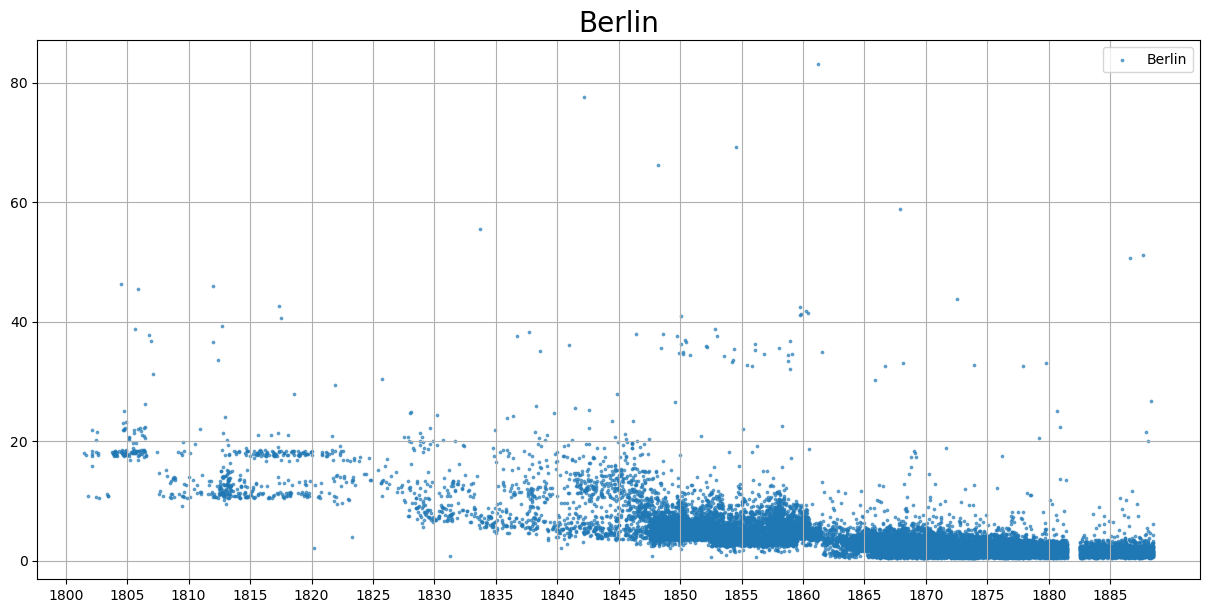

In [98]:
plot_speed_distribution('Berlin')

In [ ]:
#data = data.rolling(rolling, min_periods=1).mean().reindex(timerange)

In [141]:
st_df['Paris'].fillna('ffill')

1802    11.614583
1803         10.6
1804    11.669231
1805    11.794872
1806    12.914286
          ...    
1884     2.249344
1885     2.312704
1886     2.324627
1887     2.059211
1888     2.027304
Name: Paris, Length: 87, dtype: object

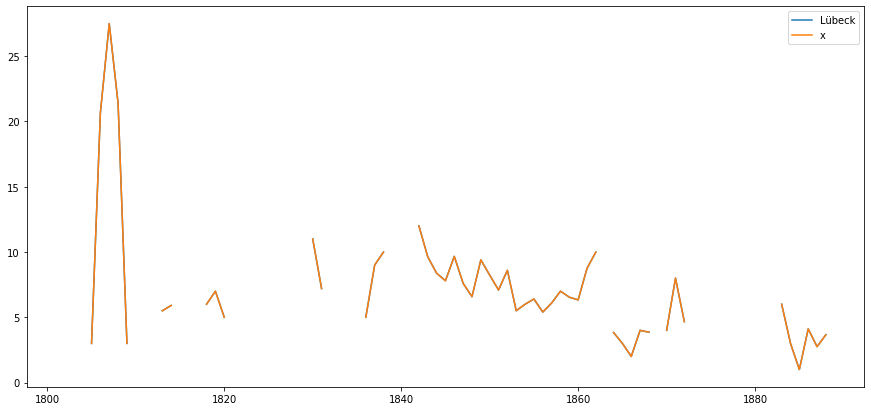

In [176]:
plt.figure(figsize=(15,7))
st_df['Lübeck'].plot()
st_df['Lübeck'].rolling(1, min_periods=1).mean().reindex(range(1802,1889)).plot(label='x')
plt.legend()
plt.show()

In [ ]:
plt.savefig()

matplotlib.axes._subplots.AxesSubplot

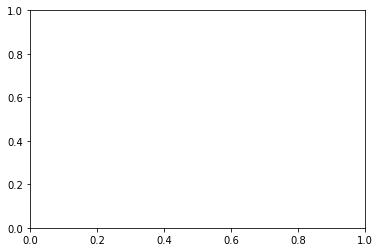

In [115]:
fig, ax = plt.subplots()
plt.savefig()
type(ax)

In [471]:
#df = df[df.placename.isin(allowed_placenames)]

In [86]:
def get_mean(names, timerange=range(1802, 1889), rolling=3, kind='line'):
    
    plt.figure(figsize=(15,7))
    
    for name in names:
        data = df[(df.placename == name) & (df.doc_date.dt.year.isin(timerange))].groupby(df.doc_date.dt.year)['delta'].mean()
        if rolling:
            data = data.rolling(rolling, min_periods=1).mean().reindex(timerange)
        else:
            data = data.reindex(timerange)
            
        avg_speed = round(df.delta[(df.placename == name) & (df.doc_date.dt.year.isin(timerange))].mean(), 1)
        count = len(df[(df.placename == name) & (df.doc_date.dt.year.isin(timerange))])
        
        if kind == 'line':
            #plt.plot(data, label=name)
            data.plot(label=name)
        elif kind == 'scatter':
            plt.scatter(x=timerange, y=data, s=5, label=f'{name}: {count} entries, avg {avg_speed} days')
    
    plt.xticks(ticks=timerange, labels=[str(yr) if yr%5==0 else '' for yr in timerange])
    plt.ylabel('days', size=14)
    #plt.minorticks_on()
    plt.grid(which='major', linewidth=1.2)                
    plt.legend(fontsize=12)
    plt.show()

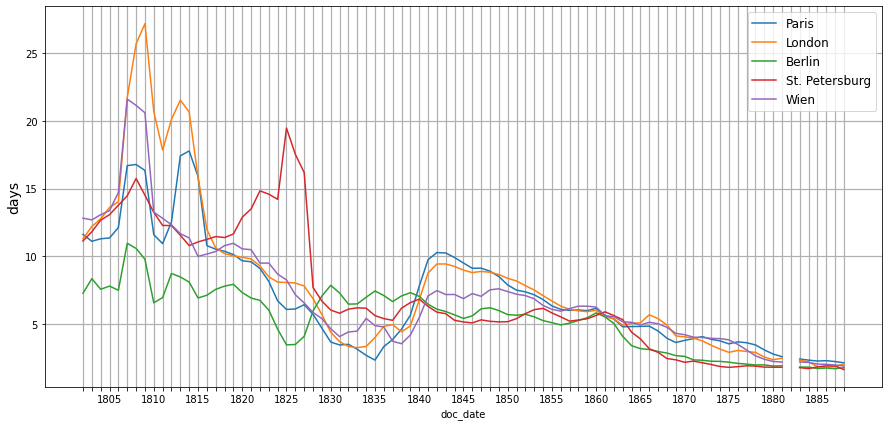

In [88]:
get_mean(allowed_placenames[:5], rolling=3, kind='line')

In [79]:
test_data.plot.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

ValueError: values must be a 1D array

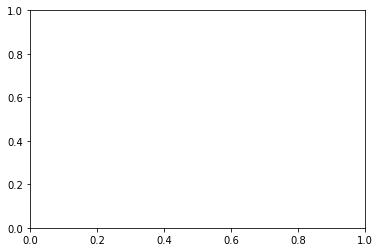

In [76]:
plt.plot(test_data.reindex(range(1802,1889)))

In [20]:
len(df[(df.placename == 'Rom') & (df.doc_date.dt.year.isin(range(1802,1889)))])

,doc_id,doc_date,placename,day,day2,month,month2,origin_year,start,end,origin_date,delta
273,534,1802-07-05,Rom,7,<NA>,6,<NA>,<NA>,0,19,1802-06-07,28
519,933,1802-11-19,Rom,23,<NA>,10,<NA>,<NA>,0,18,1802-10-23,27
586,1050,1803-01-03,Rom,14,<NA>,12,<NA>,<NA>,0,18,1802-12-14,20
1125,1885,1803-10-10,Rom,10,<NA>,9,<NA>,<NA>,0,19,1803-09-10,30
1388,2308,1804-02-27,Rom,28,<NA>,1,<NA>,<NA>,0,21,1804-01-28,30
...,...,...,...,...,...,...,...,...,...,...,...,...
246487,289448,1888-12-12,Rom,23,11,12,<NA>,<NA>,2471,2496,1888-12-11,1
246521,289539,1888-12-17,Rom,26,14,12,<NA>,<NA>,22,48,1888-12-14,3
246522,289539,1888-12-17,Rom,27,15,12,<NA>,<NA>,466,491,1888-12-15,2
246547,289579,1888-12-21,Rom,31,19,12,<NA>,<NA>,255,280,1888-12-19,2


In [60]:
# vorigen monat on valepidi!?
# 12-1 asemele 11/12-1/2
# pigem teha nii, et kui pole just järgmine kuu, on automaatselt eelmine aasta?

In [492]:
def debug_example(ix, df):
    doc_ix = df.loc[ix, 'doc_id']
    print(doc_ix)
    print(df.loc[ix, 'placename'])
   # print(main_df.loc[doc_ix, 'date'], '\n')
    print(df.loc[ix, ['day', 'day2', 'month', 'month2', 'doc_date']], '\n')
    print(verify_dates(ix, df))
    print(main_df.loc[doc_ix, 'full_text'])

In [286]:
loaded_df.loc[108836, 'doc_date'] - (loaded_df.loc[108836, 'origin_date'] - pd.)

Timedelta('-160 days +00:00:00')

In [501]:
debug_example(11673, df)

18832
Brüssel
day                          24
day2                       <NA>
month                         9
month2                     <NA>
doc_date    1816-01-05 00:00:00
Name: 11673, dtype: object 

1816-09-12 00:00:00
Brüssel, den 24sten September.

	Der Stadt Antwerpen sind von Seiner
Majestät die Docken (mit Schleusen versehene Bassins, in welchen die Schiffe ausgebessert werden) zum Bestendes Kaufhan. dels mit allem dazu gehörigen Terrain als Eigenthum geschenkt worden. .Bekanntlicy hatdiese Napoleon mit ausnehmendem Aufwände zum Behuf seiner Kriegeflotte anlegen lassen.
Zwischen unsenn Könige und dem Kartton Zürich ist eine Kapitulation geschlossen und ratificirt worden , in Betreff eineS Schweizer-Regiments des besagten Kan« tons, das in niederländische Dienste tritt.
Die heftigen Stürme, welche an unsern Küsten herrschen, verhindern die T&gt; v.ß; portschiffe abzusegeln, und die Städte Calais, Boulogne und Ostende sind voll von cngliftpen Truppen, welche günstige Witterung, 

In [83]:
day_jul = convertdate.julian.from_gregorian(year=1856, month=3, day=2)
print(day_jul)

(1856, 2, 19)


In [252]:
sample = main_df.sample()
print(sample.date.values[0], '\n')
print(sample.full_text.values[0])

1833-06-22 

Die Behörden sind äußerst wachsam und beobachte» M mentltch alle Fremden mit großer Aufmerksamkeil. 3 Tagen haben viele Haussuchungen stattgefunden. 2*° auö Frankreich angekommene Reisende, die man im dacht des Einverständnisses mit dem &lt;?r-Minister werbe hat, stehen unter strenger Aufsicht. wurde ein Französischer HandlungSkommiS in de« %4p dllcke verhaftet, wo er nach Bayonne abreisen wollte; f«n Koffer ward geöffnet, und in einer alten Bn'eftasche fanden sich Briefe ohne Unterschrift an den Grafen von VIM und an Herrn Calomarde vor, in denen von der flttflf M Infanten Don Carlos und von eine« Kern von «nbängm,

	Madrid, den 11. Juni.

	die in den nördlichen Provinzen, namentlich in Katalonien, versammelt seyen, die Rede war. Die Regierung hat sofort Stafetten an die Generalkaoi:aine dieser Provinzen mit energischen Befehlen abgesandt, den Unruhen durch Verhaftung der Rädelsführer vorzube igen.
AuS Bilbao wird gemeldet, daß d.r dorfige Magistrat sich dem Einrücken eia

In [194]:
test_df

,date,year,month,day,pub,heading,full_text,href,text_len,placename,origin_date,origin_month,heading2
158691,1862-12-12,1862,12,12,Rigasche Zeitung,Holland.,"Holland.\n\n\tHaag, 13. (1.) December. sKöln.Z...",https://proc.dom.lndb.lv/file.axd?id=15287209&...,696,None,None,None,Holland
120911,1854-04-05,1854,4,5,Rigasche Zeitung,Inländische Nachrichten.,Inländische Nachrichten.\n\n\tTt. Petersburg. ...,https://proc.dom.lndb.lv/file.axd?id=12135834&...,7271,None,None,None,Inländische Nachrichten
218663,1874-07-13,1874,7,13,Rigasche Zeitung,Das Attentat und die Reaction.,Das Attentat und die Reaction.\n\n\tIn dem Kam...,https://proc.dom.lndb.lv/file.axd?id=11835060&...,9780,None,None,None,Das Attentat und die Reaction
158839,1862-12-22,1862,12,22,Rigasche Zeitung,Oesterreich.,"Oesterreich.\n\n\tWien, 27. (15.) December. De...",https://proc.dom.lndb.lv/file.axd?id=4374749&a...,2573,None,None,None,Oesterreich
204682,1871-10-13,1871,10,13,Rigasche Zeitung,Benedetti und Lessinnes,"Benedetti und Lessinnes\n\n\tL. Berlin, 22. (1...",https://proc.dom.lndb.lv/file.axd?id=13290475&...,5345,None,None,None,Benedetti und Lessinnes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66739,1841-09-02,1841,9,2,Rigasche Zeitung,"Paris, den 3. September.","Paris, den 3. September.\n\n\tIm „Moniteur par...",https://proc.dom.lndb.lv/file.axd?id=8950120&a...,4589,Paris,3,Sept,Paris
4746,1806-01-20,1806,1,20,Rigasche Zeitung,"Folgende Personen sind gesonnen, bon hier Zu r...","Folgende Personen sind gesonnen, bon hier Zu r...",https://proc.dom.lndb.lv/file.axd?id=8565650&a...,717,None,None,None,Folgende Personen sind gesonnen von hier zu re...
10539,1810-03-26,1810,3,26,Rigasche Zeitung,"Madrid, den 28. Februar.","Madrid, den 28. Februar.\n\n\tUnter den Zügen,...",https://proc.dom.lndb.lv/file.axd?id=15202948&...,1403,Madrid,28,Feb,Madrid
119315,1853-12-19,1853,12,19,Rigasche Zeitung,Inländische Nachrichten.,Inländische Nachrichten.\n\n\n\tSt. Petersburg...,https://proc.dom.lndb.lv/file.axd?id=4090652&a...,2616,None,None,None,Inländische Nachrichten


In [195]:
scan_placenames_dates(test_df, exceptions)

0it [00:00, ?it/s]

,doc_id,doc_date,placename,day,day2,month,start,end,year
0,158691,1862-12-12,Haag,13,1,Dec,11,29,1862
1,158839,1862-12-22,Wien,27,15,Dec,15,34,1862
2,204682,1871-10-13,Berlin,22,10,Oct,29,50,1871
3,11239,1810-08-06,Paris,27,<NA>,Jul,1569,1590,1810
4,130806,1856-06-26,Kopenhagen,2,<NA>,Jul,12,30,1856
...,...,...,...,...,...,...,...,...,...
10379,110045,1852-01-26,Brüssel,31,<NA>,Jan,0,16,1852
10380,64985,1841-01-04,Konstantinopel,23,<NA>,Dec,0,27,1841
10381,66739,1841-09-02,Paris,3,<NA>,Sept,0,18,1841
10382,10539,1810-03-26,Madrid,28,<NA>,Feb,0,19,1810


In [201]:
pattern2

re.compile(r'(?P<placename>(([A-Za-züöäSß]{3,}(?=\sGr[eä]nze))\s|St.\s|Bad\s|San\s|Buenos\s|New\s|[A-ZÜÖÄ][a-züöäSß]{2,}\s?[-–=]\s?|[A-ZÜÖÄ][a-züöäSß]{3,}\s[Aa]m\s)?[A-ZÜÖÄ][a-züöäSß]{3,})(?:\.|,|\.,)\s*(?:([Dd]en)|([Vv]om)|([Dd]em)|([Dd]er»)|([Dd]er))?\s*(?P<date>\d{1,2})(?:\.|ten|sten)?\s*(?P<date2>\(\d{1,2}\.?(\s)?\))?\s+(?P<month>([Jj]an)|([Ff]eb)|([Mm][äa]r)|([Aa]pr)|([Mm]ai)|([Jj][un]n)|([Jj][un]l)|([Aa]ug)|([Ss]ept)|([Oo]ct)|([Nn]ov)|([Dd]e[cz])|(c\.?)|(d\.\sM\.?)|(v\.\sM\.?))\n',
re.UNICODE)

In [204]:
pattern2

re.compile(r'(?P<placename>(([A-Za-züöäSß]{3,}(?=\sGr[eä]nze))\s|St.\s|Bad\s|San\s|Buenos\s|New\s|[A-ZÜÖÄ][a-züöäSß]{2,}\s?[-–=]\s?|[A-ZÜÖÄ][a-züöäSß]{3,}\s[Aa]m\s)?[A-ZÜÖÄ][a-züöäSß]{3,})(?:\.|,|\.,)\s*(?:([Dd]en)|([Vv]om)|([Dd]em)|([Dd]er»)|([Dd]er))?\s*(?P<date>\d{1,2})(?:\.|ten|sten)?\s*(?P<date2>\(\d{1,2}\.?(\s)?\))?\s+(?P<month>([Jj]an)|([Ff]eb)|([Mm][äa]r)|([Aa]pr)|([Mm]ai)|([Jj][un]n)|([Jj][un]l)|([Aa]ug)|([Ss]ept)|([Oo]ct)|([Nn]ov)|([Dd]e[cz])|(c\.?)|(d\.\sM\.?)|(v\.\sM\.?))\n',
re.UNICODE)

In [205]:
with open('placename_replacement_dict.json', 'r', encoding='utf8') as f:
    placename_replacement_dict = json.load(f)

In [281]:
df = pd.read_csv('processed_data.tsv', sep='\t', encoding='utf8').convert_dtypes()

In [282]:
df['doc_date'] = pd.to_datetime(df['doc_date'])

In [283]:
df['origin_date'] = pd.to_datetime(df['origin_date'])

In [284]:
df[df.placename == 'Paris']

,doc_id,doc_date,placename,day,day2,month,start,end,year,origin_date,delta
1,1,1802-01-01,Paris,18,<NA>,12,<NA>,20,1802,1801-12-18,14
17,20,1802-01-08,Paris,25,<NA>,12,<NA>,21,1802,1801-12-25,14
32,45,1802-01-15,Paris,1,<NA>,1,<NA>,20,1802,1802-01-01,14
35,53,1802-01-18,Paris,6,<NA>,1,<NA>,19,1802,1802-01-06,12
47,73,1802-01-25,Paris,8,<NA>,1,<NA>,19,1802,1802-01-08,17
...,...,...,...,...,...,...,...,...,...,...,...
243508,289479,1888-12-14,Paris,28,11,12,<NA>,20,1888,1888-12-11,3
243522,289519,1888-12-16,Paris,27,15,12,1532,1552,1888,1888-12-15,1
243527,289557,1888-12-19,Paris,29,17,12,<NA>,20,1888,1888-12-17,2
243531,289558,1888-12-19,Paris,30,13,12,1880,1900,1888,1888-12-13,6


243569

In [260]:
placename_replacement_dict

{'Petersburg': 'St. Petersburg',
 'Trieft': 'Triest',
 'Pesth': 'Pest',
 'Pefth': 'Pest',
 'Verlin': 'Berlin',
 'Maingegenden': 'Main',
 'Janeiro': 'Rio de Janeiro',
 'Bucharest': 'Bukarest',
 'Vondon': 'London',
 'Loudon': 'London',
 'Rewyork': 'New York',
 'Newyork': 'New York',
 'Ncwyork': 'New York',
 'Newyort': 'New York',
 'New-York': 'New York',
 'Ntwyork': 'New York',
 'Pans': 'Paris',
 'PanS': 'Paris',
 'Parts': 'Paris',
 'PartS': 'Paris',
 'Baris': 'Paris',
 'PariS': 'Paris',
 'Konftantinopel': 'Konstantinopel',
 'Konstautinopel': 'Konstantinopel',
 'Koustantinopel': 'Konstantinopel',
 'Konstantmopel': 'Konstantinopel',
 'Constantinopel': 'Konstantinopel',
 'Kalkutta': 'Calcutta',
 'Niga': 'Riga',
 'Riza': 'Riga',
 'Rlga': 'Riga',
 'Kiga': 'Riga',
 'Rcval': 'Reval',
 'Neval': 'Reval',
 'Torpat': 'Dorpat',
 'DomeSneeS': 'Domesnees',
 'DomesneeS': 'Domesnees',
 'DomeSnees': 'Domesnees',
 'Domcsnees': 'Domesnees',
 'Snees': 'Domesnees',
 'Boldcraa': 'Bolderaa',
 'Sselo': 'Zarsko